In [1]:
import pandas as pd 
import geopandas as gpd
from geopandas import GeoDataFrame
import os
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pylab as plt
import math
import matplotlib as mpl
import seaborn as sns
#import matplotlib.pylab as pl

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.statespace as smstate

from statsmodels.graphics.api import qqplot
 
pd.options.mode.chained_assignment = None
%matplotlib inline

In [2]:
data = pd.read_csv('study_data_sales_price0719.csv',index_col=[0], parse_dates=['sale_date'])
data.head()

,address,apartment_number,block,borough,building_class_as_of_final_roll_17/18,building_class_as_of_final_roll_18/19,building_class_at_present,building_class_at_time_of_sale,building_class_category,commercial_units,...,sale_date,sale_price,tax_class_as_of_final_roll_17/18,tax_class_as_of_final_roll_18/19,tax_class_at_present,tax_class_at_time_of_sale,total_units,year_built,zip_code,bbl
9280,278 HOYT STREET,,422,3,NaN,NaN,A5,A5,01 ONE FAMILY HOMES,0.0,...,2007-06-01,1795000,NaN,NaN,1,1,1.0,2006.0,11217.0,3004220143
9284,131 SUMMIT STREET,,354,3,NaN,NaN,B9,B9,02 TWO FAMILY HOMES,0.0,...,2007-05-23,1417250,NaN,NaN,1,1,2.0,1899.0,11231.0,3003540044
9285,216 CARROLL STREET,,356,3,NaN,NaN,B9,B9,02 TWO FAMILY HOMES,0.0,...,2007-11-05,1775000,NaN,NaN,1,1,2.0,1899.0,11231.0,3003560019
9286,119 RAPELYEA STREET,4,364,3,NaN,NaN,B1,B1,02 TWO FAMILY HOMES,0.0,...,2007-06-01,1750000,NaN,NaN,1,1,2.0,1930.0,11231.0,3003640034
9288,32 3 PLACE,,370,3,NaN,NaN,B9,B9,02 TWO FAMILY HOMES,0.0,...,2007-08-03,1445300,NaN,NaN,1,1,2.0,1899.0,11231.0,3003700020


#### smoothing if has error: is moving average smoothing which replaces each element of the series by either the simple or weighted average of n surrounding elements, where n is the width of the smoothing "window". ( use median) 

In [3]:
time_price = data[['sale_date','sale_price']]
df_time = time_price.set_index(['sale_date'])
df_time.head()

,sale_price
sale_date,
2007-06-01,1795000
2007-05-23,1417250
2007-11-05,1775000
2007-06-01,1750000
2007-08-03,1445300


In [4]:
time_price_means = df_time.resample('M').mean()
time_price_means.head()

,sale_price
sale_date,
2007-01-31,1.389184e+06
2007-02-28,8.950000e+05
2007-03-31,1.327917e+06
2007-04-30,1.487889e+06
2007-05-31,1.000352e+06


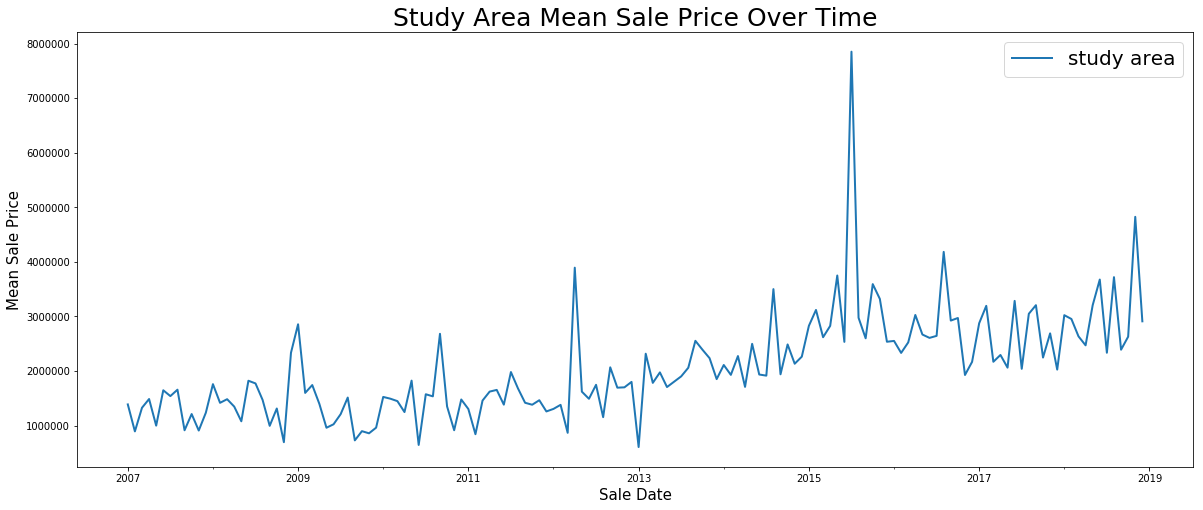

In [5]:
# Visulize the data 

f, ax = plt.subplots(figsize=(20,8))
time_price_means ['sale_price'].plot(alpha=1,linewidth=2,ax=ax,label='study area')
plt.title("Study Area Mean Sale Price Over Time", fontsize=25)
plt.xlabel("Sale Date", fontsize=15)
plt.ylabel("Mean Sale Price", fontsize=15)
plt.legend(prop={'size': 20})
plt.show()

## Explore the seasonality and trend
### Two methods:
#### Differencing (taking the differece with a particular time lag) 
#### Decomposition (modeling both trend and seasonality and removing them from the model)

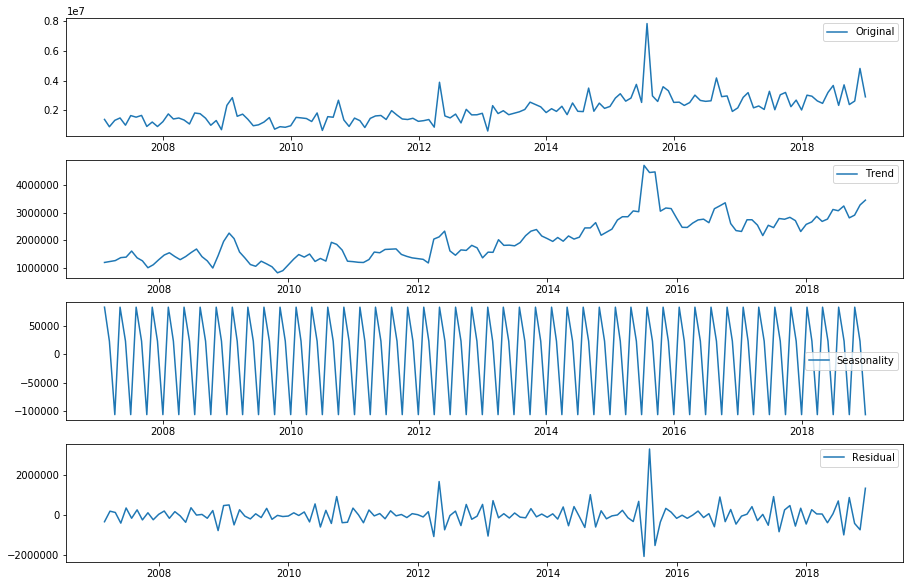

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(time_price_means,freq=3)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

f, ax = plt.subplots(figsize=(15,10))
plt.subplot(411)
plt.plot(time_price_means, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residual')
plt.legend(loc = 'best')

### View Yearly and Monthly Trend (dont run)

In [11]:
time_price_means.reset_index(inplace=True)

In [13]:
time_price_means.head()

,index,sale_date,sale_price
0,0,2007-01-31,1.389184e+06
1,1,2007-02-28,8.950000e+05
2,2,2007-03-31,1.327917e+06
3,3,2007-04-30,1.487889e+06
4,4,2007-05-31,1.000352e+06


In [16]:
# Prepare data
time_price_means['year'] = [d.year for d in time_price_means.sale_date]
time_price_means['month'] = [d.strftime('%b') for d in time_price_means.sale_date]
years = time_price_means['year'].unique()


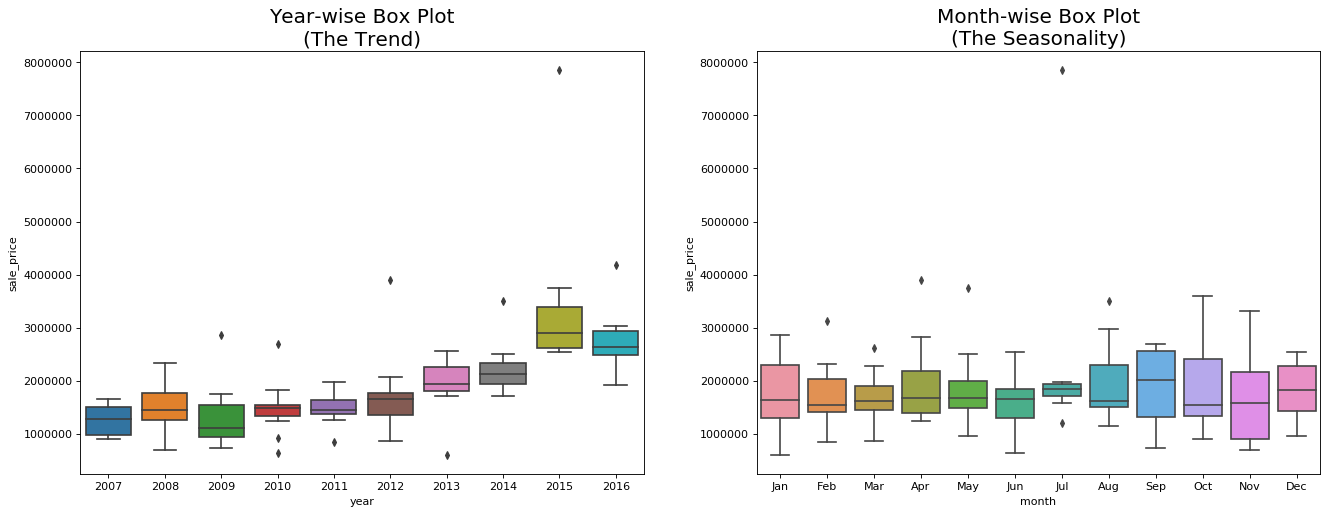

In [17]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='sale_price', data=time_price_means, ax=axes[0])
sns.boxplot(x='month', y='sale_price', data=time_price_means.loc[~time_price_means.year.isin([2007, 2016]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

## Check stationary

#### A stationary time series is one where statistical properties — like the mean and variance — are constant over time.Most statistical forecasting methods are designed to work on a stationary time series. The first step in the forecasting process is typically to do some transformation to convert a non-stationary series to stationary. Now we test if our data is staionary: 

In [7]:
# ADF Test and KPSS Test to measure the stationarity of the data 
result = adfuller(time_price_means.sale_price.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(time_price_means.sale_price.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.3125617545283461
p-value: 0.6234058799406687
Critial Values:
   1%, -3.47864788917503
Critial Values:
   5%, -2.882721765644168
Critial Values:
   10%, -2.578065326612056

KPSS Statistic: 0.926708
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/Users/amber/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


#### Based on the ADF test we did before, the p-valur is lower than 5%, thus we can reject the nun hypothesis and accept that stationarity exists in the data.

## Make data from non-staionary to stationary 

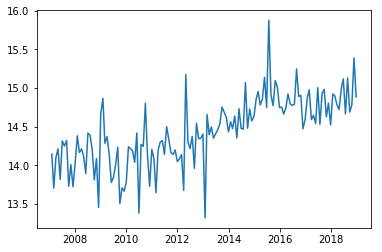

In [8]:
price_log = np.log(time_price_means)
plt.plot(price_log)

In [9]:

time_price_means['diff_price'] = time_price_means.sale_price -time_price_means.sale_price.shift(6)
time_price_means.dropna(inplace= True)
time_price_means.head()


,sale_price,diff_price
sale_date,,
2007-07-31,1.541417e+06,152232.512821
2007-08-31,1.658950e+06,763950.000000
2007-09-30,9.155400e+05,-412376.666667
2007-10-31,1.212889e+06,-275000.000000
2007-11-30,9.105547e+05,-89797.761905


In [10]:
# ADF Test and KPSS Test to measure the stationarity of the data 
result = adfuller(time_price_means.diff_price.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -3.7734021496746433
p-value: 0.00319147466284833
Critial Values:
   1%, -3.4833462346078936
Critial Values:
   5%, -2.8847655969877666
Critial Values:
   10%, -2.5791564575459813


In [11]:
time_price_means_new = time_price_means[['sale_price']]

####  We know that the ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information.

ACF Value:
PACF Value:


/Users/amber/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


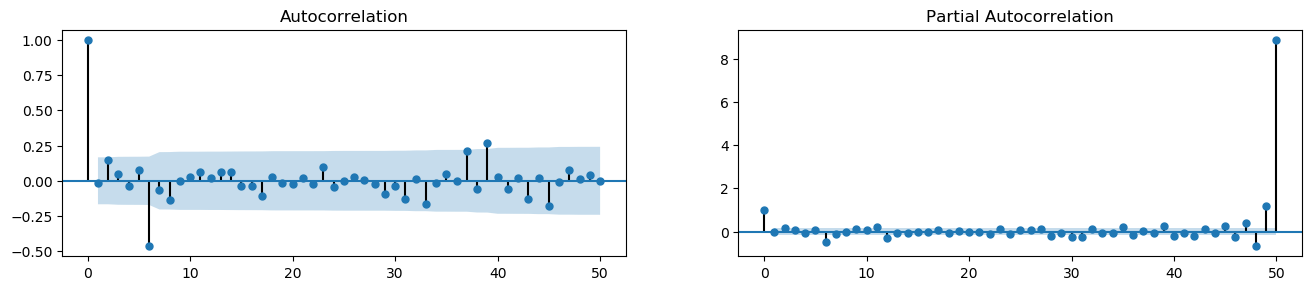

In [12]:

from pandas import Series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(time_price_means.diff_price.tolist(), lags=50, ax=axes[0])
print("ACF Value:")
#print(acf(time_price_means))


plot_pacf(time_price_means.diff_price.tolist(), lags=50, ax=axes[1])
print("PACF Value:")
#print(pacf(time_price_means))

In [13]:
import itertools
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [22]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(time_price_means,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

### BEST : 
#### ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:3417.999547523359

In [15]:
import statsmodels.api as sm 
mod = sm.tsa.statespace.SARIMAX(time_price_means_new.sale_price,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2316      0.180     -1.283      0.199      -0.585       0.122
ma.L1         -0.6977      0.117     -5.951      0.000      -0.927      -0.468
ar.S.L12      -0.0133      0.197     -0.067      0.946      -0.399       0.373
ma.S.L12      -0.9123      0.063    -14.390      0.000      -1.037      -0.788
sigma2      1.106e+12    4.2e-14   2.63e+25      0.000    1.11e+12    1.11e+12


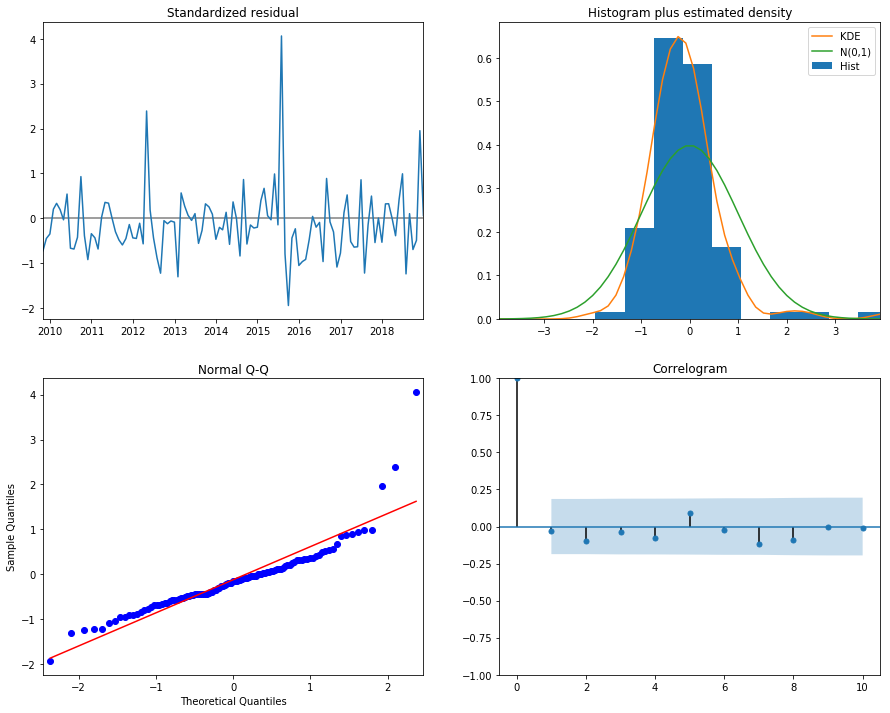

In [16]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

## Validating Forecasts

In [17]:
pred = results.get_prediction(start=pd.to_datetime('2016-01-31'), dynamic=False)
pred_ci = pred.conf_int()

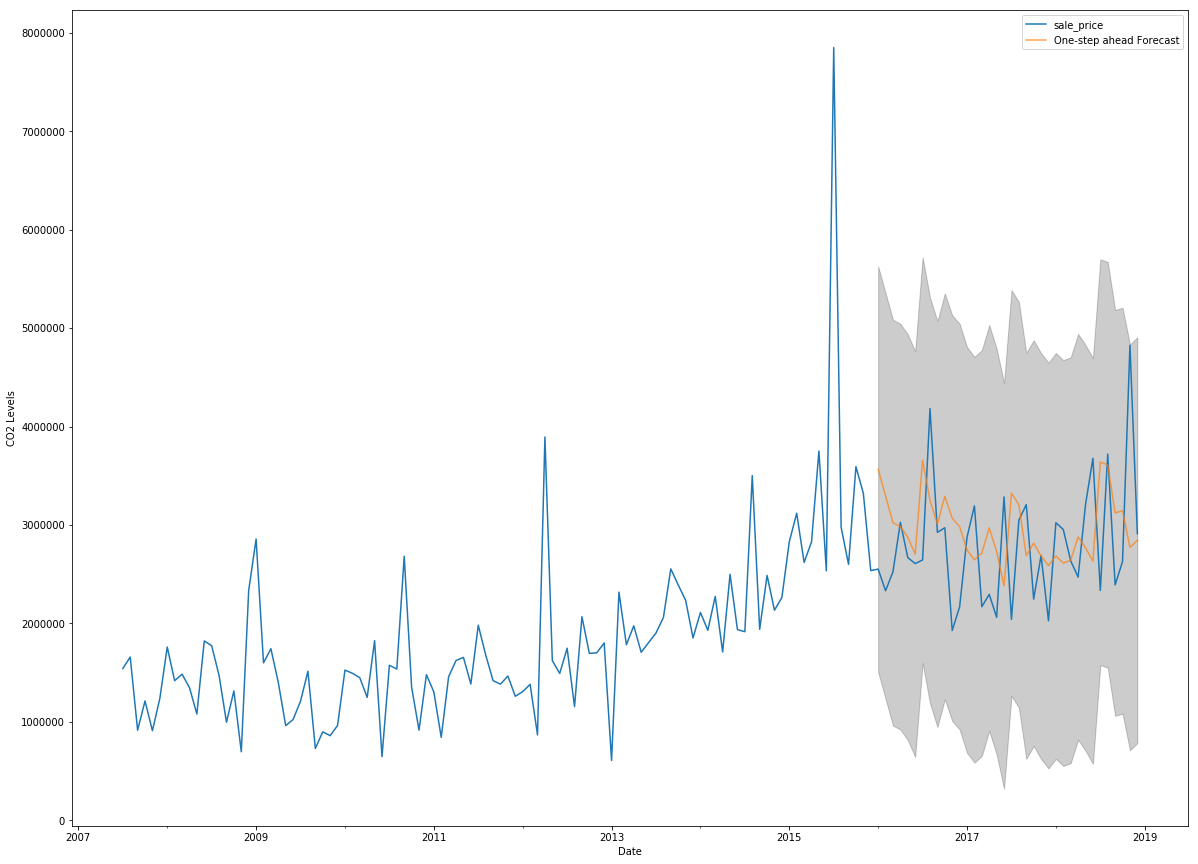

In [18]:


ax =time_price_means_new['2007':].plot(label='observed',figsize=(20, 15))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

In [19]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=50)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

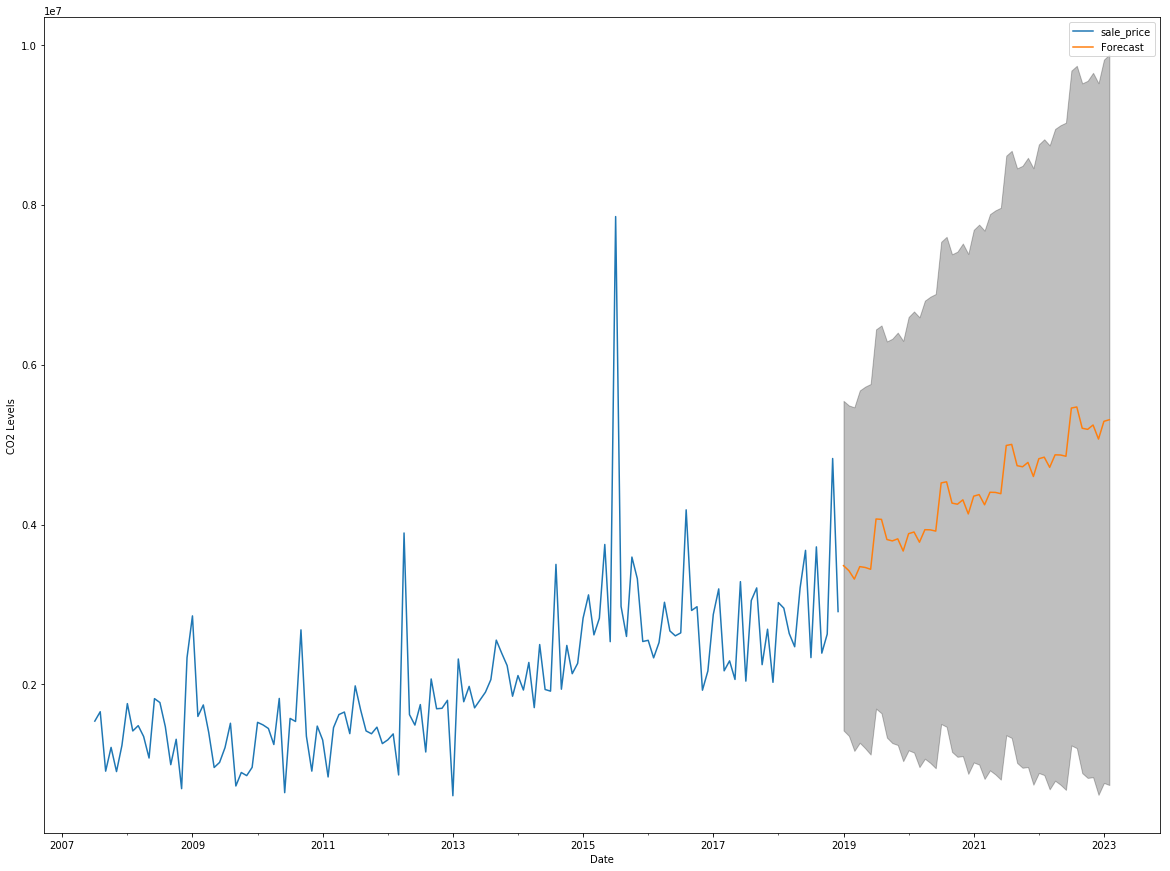

In [20]:
ax =  time_price_means_new.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

# Next Step:
### 1.Improve Model accuracy 
### 2.Add zoning change for housing units 
### 3.Output price prediction and compare with after zoning price 

In [99]:
import itertools
p = d = q = range(2)
pdq = list(itertools.product(p, d, q))      #Generate all different combinations of p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]       #Generate all different combinations of seasonal p, q and q triplet

In [71]:
min_aic = AIC_df.sort_values(by = 'AIC').iloc[0]    #Row with minimum AIC value
model = sm.tsa.statespace.SARIMAX(time_price_means, order = min_aic.param, seasonal_order = min_aic.param_seasonal, enforce_stationarity = False, enforce_invertibility = False)
results = model.fit()
#print(results.summary())
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1668      0.207     -0.805      0.421      -0.573       0.239
ma.L1         -0.7068      0.130     -5.450      0.000      -0.961      -0.453
ma.S.L12      -0.8498      0.149     -5.688      0.000      -1.143      -0.557
sigma2      1.142e+12   1.25e-13   9.11e+24      0.000    1.14e+12    1.14e+12


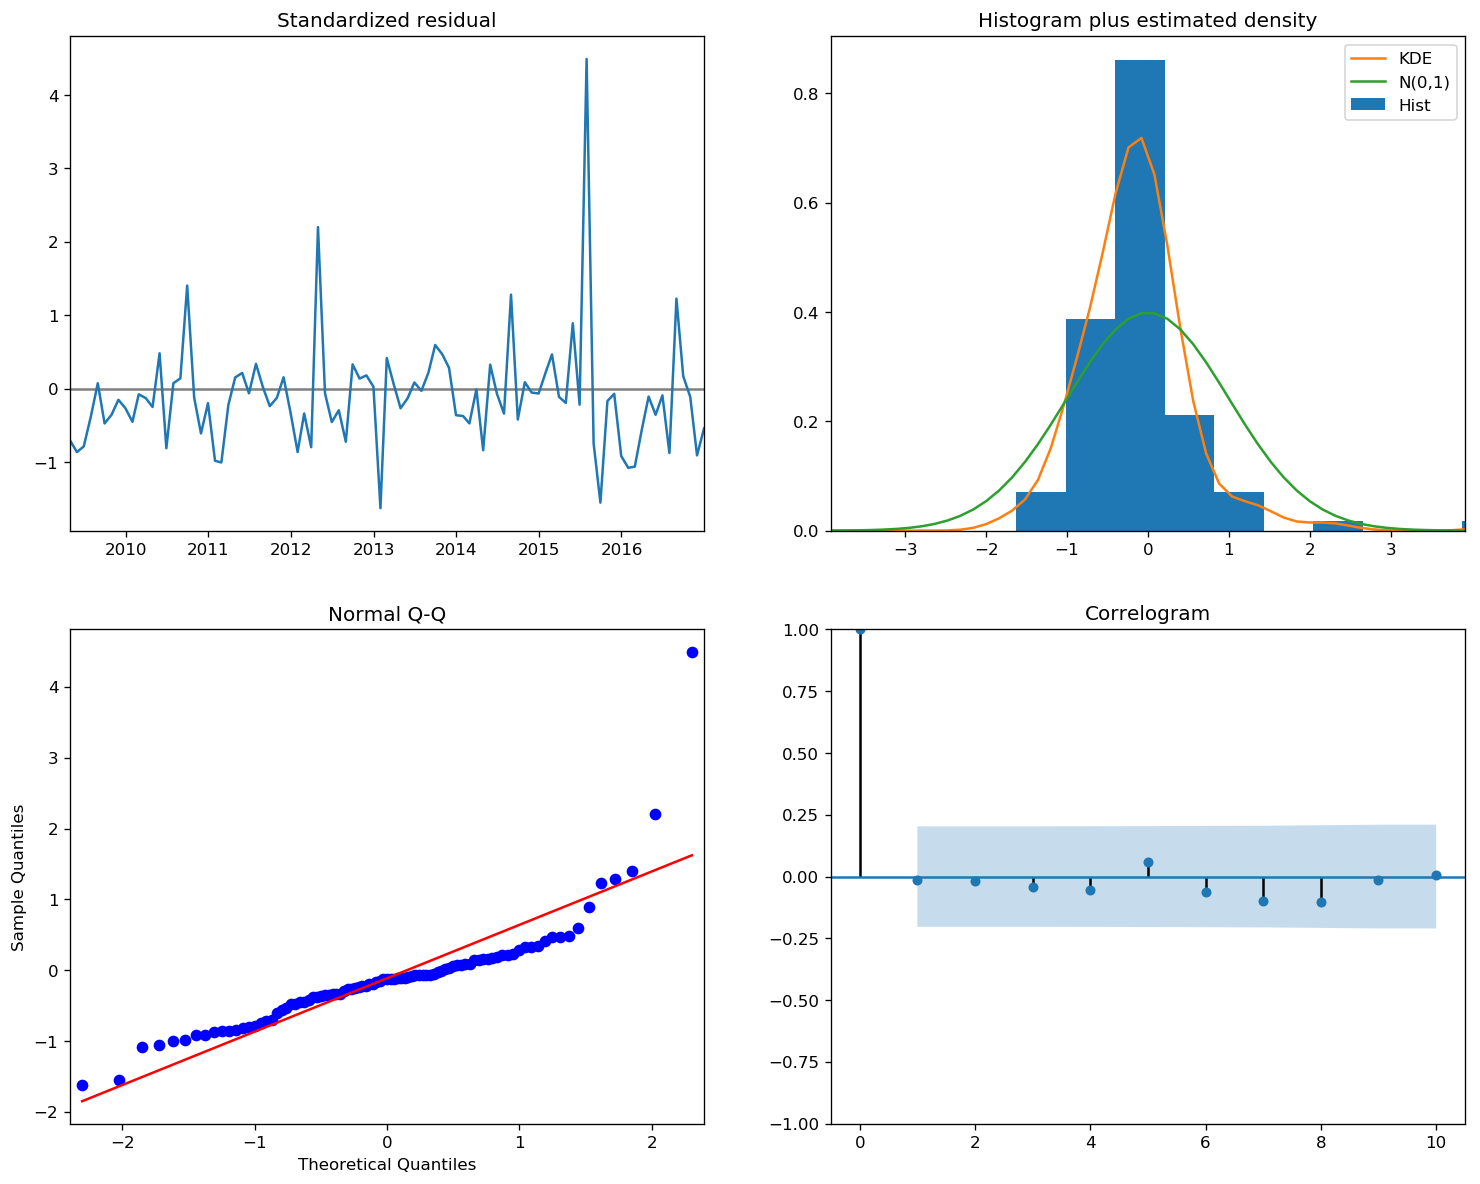

In [72]:
results.plot_diagnostics(figsize=(15, 12))    #Generate model diagnostics and investigate for any unusual behavior.
plt.show()

In [84]:
#Obtain values for forecasts of the time series from 1958
pred = results.get_prediction(start = pd.to_datetime('2015-01-31'), dynamic = False)
#Obtain associated confidence intervals for forecasts of the time series
pred_ci = pred.conf_int()
pred_ci.head()

,lower sale_price,upper sale_price
sale_date,,
2015-01-31,497193.967886,4.686652e+06
2015-02-28,525566.938590,4.715025e+06
2015-03-31,643469.440181,4.832927e+06
2015-04-30,939201.358005,5.128659e+06
2015-05-31,702945.161242,4.892403e+06


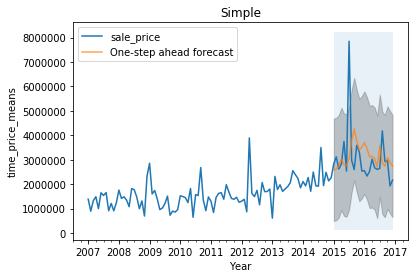

In [128]:
#Plot the forecasted values with historical data
ax = time_price_means['2007':].plot(label = 'observed')
pred.predicted_mean.plot(ax = ax, label = 'One-step ahead forecast', alpha = 0.7)
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color = 'k', alpha = .2)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-01-31'), time_price_means.index[-1], alpha = .1, zorder = -1)
plt.xlabel('Year')
plt.ylabel('time_price_means')
plt.title('Simple')
plt.legend()

In [ ]:
fig = pl.figure(figsize=(15,15))

for key, item in results_list.items():
    pred = item.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
    pred_ci = pred.conf_int()
    
    y_forecasted = pred.predicted_mean
    y_truth = mta_centers.loc[key]['2017-01-01':]

    # Compute the mean square error
    mse = ((y_forecasted - y_truth) ** 2).mean()

    ax = fig.add_subplot(3,2,key+1)
    mta_centers.loc[key].plot(ax=ax, label='Observed', color='dodgerblue', lw=2)
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', color='darkorange', lw=2)

    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='darkgray', alpha=.5)

    ax.set_xlabel('Date')
    ax.set_ylabel('Standardized Ridership')
    ax.set_title('MTA Cluster {} - MSE: {:.2f}'.format(key, mse))
    pl.legend()

pl.tight_layout()
pl.show()

In [91]:
pred.predicted_mean.head()

sale_date
2015-01-31    2.591923e+06
2015-02-28    2.620296e+06
2015-03-31    2.738198e+06
2015-04-30    3.033930e+06
2015-05-31    2.797674e+06
Freq: M, dtype: float64

In [95]:
price_forecasted = pred.predicted_mean     #From 1958 to 1960 (validation process)
price_original = time_price_means['2018-01-31':]
mse = ((price_forecasted - price_original) ** 2).mean()  #Mean square error
print('Mean Squared Error of forecast : {}'.format(round(mse,3)))

Mean Squared Error of forecast : sale_price   NaN
dtype: float64


In [ ]:
ts_log_forecasted_dyna = pred_dynamic.predicted_mean
ts_log_truevalue = ts_log['1958-01-01':]
mse = ((ts_log_forecasted_dyna - ts_log_truevalue) ** 2).mean()
print('Mean Squared Error of forecast : {}'.format(round(mse, 3)))

In [ ]:
#### All the ACF values are lower than the critical value alpha = 0.5 

In [42]:
# SARIMA